# Kepler Problem with Projected ODE Solvers

This notebook demonstrates the `ProjectedOdeSolver` from `invflow.adaptive` - a flexible framework for invariant-preserving numerical integration that works with any SciPy ODE solver.

**Key Features:**
- Generic wrapper for any SciPy ODE solver (RK45, RK23, DOP853, etc.)
- Customizable projection methods for invariant preservation
- Comprehensive performance analysis with timing and conservation metrics
- Clean, modular architecture for research and production use

The Kepler problem provides an excellent test case with well-known invariants:
1. **Energy (Hamiltonian)**: $H = \frac{p_x^2 + p_y^2}{2} - \frac{1}{\sqrt{q_x^2 + q_y^2}}$
2. **Angular momentum**: $L_z = q_x p_y - q_y p_x$

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp


# Add the parent directory to sys.path to import invflow modules
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

## Define the Kepler Problem

We'll use the `ConservativeODE` class to set up the Kepler problem, which automatically provides the correct symbolic representation, equations of motion, and invariants.

The Kepler problem has the Hamiltonian:
$$H(q_x, q_y, p_x, p_y) = \frac{p_x^2 + p_y^2}{2\mu} - \frac{k}{\sqrt{q_x^2 + q_y^2}}$$

The system has multiple invariants including:
1. Energy (Hamiltonian): $H$
2. Angular momentum: $L_z = q_x p_y - q_y p_x$
3. Runge-Lenz vector components: $A_x, A_y$

In [2]:
# Set up the Kepler problem using ConservativeODE
from homproj.dynamics import HamiltonianSystem

def kepler_2d(mu=1.0, k=1.0):
    qx, qy, px, py = sp.symbols('qx qy px py', real=True)
    vars_sym = [qx, qy, px, py]
    r = sp.sqrt(qx**2 + qy**2)
    H = (px**2 + py**2)/(2*mu) - k/r
    Lz = qx*py - qy*px
    Ax = py*Lz - mu*k*qx/r
    Ay = -px*Lz - mu*k*qy/r
    invariants = [H, Lz, Ax, Ay]
    f = HamiltonianSystem(H, vars_sym).f
    return f, invariants, vars_sym

f_kepler, invariants_kepler, vars_sym_kepler = kepler_2d()

# Extract the invariants for preservation
H_sym = invariants_kepler[0]  # Energy/Hamiltonian
L_sym = invariants_kepler[1]  # Angular momentum
A_sym = invariants_kepler[2]  # Third invariant (Runge-Lenz component)

print("Kepler problem invariants:")
for i, inv in enumerate(invariants_kepler):
    print(f"Invariant {i}: {inv}")

# Create lambda functions for the invariants
H_fun = sp.lambdify(vars_sym_kepler, H_sym, 'numpy')
L_fun = sp.lambdify(vars_sym_kepler, L_sym, 'numpy')
A_fun = sp.lambdify(vars_sym_kepler, A_sym, 'numpy')

def compute_energy(state):
    if state.ndim == 1:
        return H_fun(*state)
    else:
        return np.array([H_fun(*row) for row in state])

def compute_angular_momentum(state):
    if state.ndim == 1:
        return L_fun(*state)
    else:
        return np.array([L_fun(*row) for row in state])

def compute_third_invariant(state):
    if state.ndim == 1:
        return A_fun(*state)
    else:
        return np.array([A_fun(*row) for row in state])

def kepler_rhs(t, y):
    return f_kepler(y)



Kepler problem invariants:
Invariant 0: 0.5*px**2 + 0.5*py**2 - 1.0/sqrt(qx**2 + qy**2)
Invariant 1: -px*qy + py*qx
Invariant 2: py*(-px*qy + py*qx) - 1.0*qx/sqrt(qx**2 + qy**2)
Invariant 3: -px*(-px*qy + py*qx) - 1.0*qy/sqrt(qx**2 + qy**2)


In [3]:

import time
from keplerutils import kepler_exact_elliptic
from homproj.adaptive import solve_ivp

def create_initial_state(eccentricity):
    semi_major_axis = 1.0
    mu = 1.0 
    k = 1.0
    perihelion = semi_major_axis * (1 - eccentricity)
    velocity_magnitude = np.sqrt(mu * k * (1 + eccentricity) / (mu * perihelion))
    y0 = np.array([perihelion, 0.0, 0.0, mu * velocity_magnitude])
    return y0




y0 = create_initial_state(eccentricity=0.7)

def compute_error(sol, y0):
    y_exact = kepler_exact_elliptic(y0, sol.t)
    total_error = np.linalg.norm(y_exact - sol.y, axis=0)
    return total_error
t0 = time.time()
sol = solve_ivp(
    kepler_rhs, 
    (0, 1000), 
    y0,
    method='DOP853',
    invariants=[H_fun, L_fun],
    # variables=variables,
    max_iterations=5,
    itol=1e-14,
    integrator='euler',
    rtol=1e-9
)
t1 = time.time()
print(f"Computation time (functions): {t1 - t0:.4f} seconds")
sol.error = compute_error(sol, y0)
t0 = time.time()
sol_sym = solve_ivp(
    kepler_rhs, 
    (0, 1000), 
    y0,
    method='DOP853',
    invariants=[H_sym, L_sym],
    variables=vars_sym_kepler,
    max_iterations=5,
    itol=1e-14,
    integrator='euler',
    rtol=1e-9
)
t1 = time.time()
print(f"Computation time (sympy): {t1 - t0:.4f} seconds")
sol_sym.error = compute_error(sol_sym, y0)
solutions = {'functions': sol, 'sym': sol_sym}

Computation time (functions): 0.6764 seconds
Computation time (sympy): 0.6249 seconds


# Create cost error plots

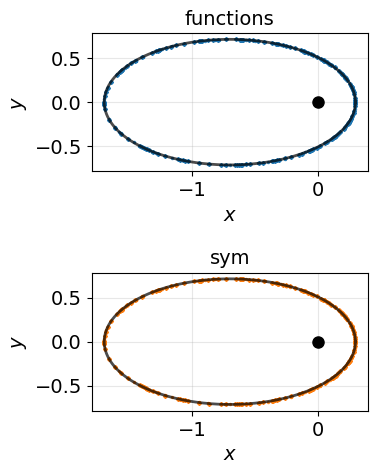

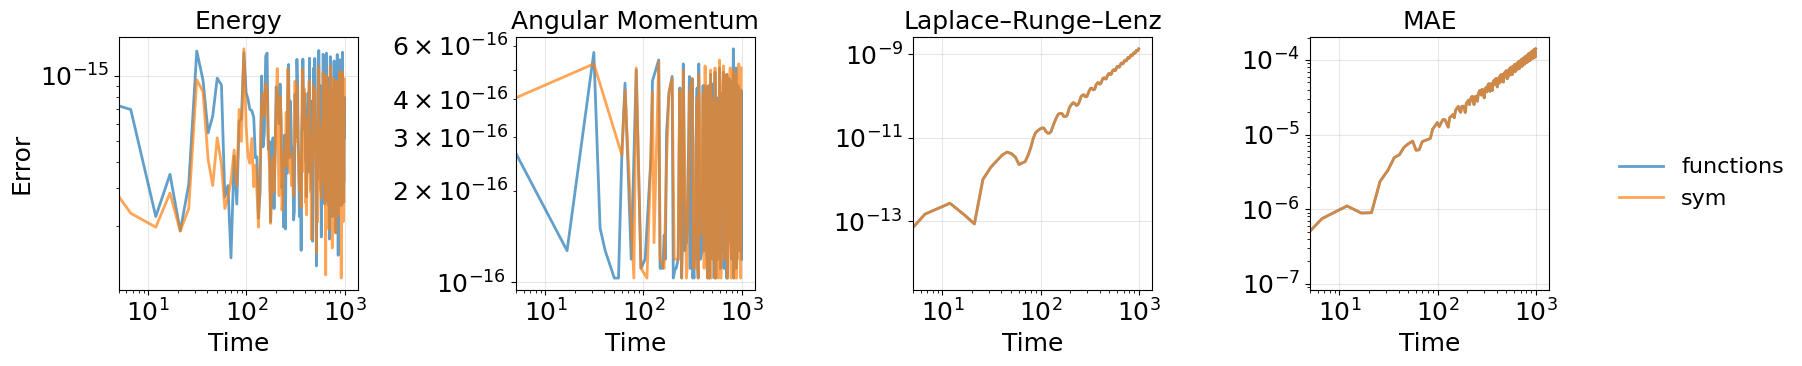

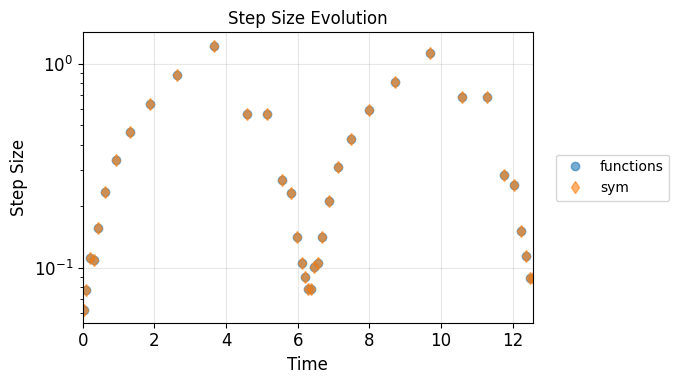

In [4]:
import pandas as pd
from keplerutils import plot_kepler_errors, plot_kepler_trajectories, plot_step_sizes, plot_error_performance_analysis

t_ref = np.linspace(0, 2*np.pi, 1000)
y_ref = kepler_exact_elliptic(y0, t_ref)

fig1 = plot_kepler_trajectories(solutions, y_ref)
fig2 = plot_kepler_errors(solutions, 
                        compute_energy,
                        compute_angular_momentum,
                        compute_third_invariant)
fig3 = plot_step_sizes(solutions, n_periods=2)
